# PM2.5 prediction

### Import libraries

In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
from scipy.stats import stats
seed(1)
from fs import methods as m
from fs import model as ml
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


### Data Import

2022-05-17 11:54:38.643998: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 11:54:38.644708: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
---------grid_0_1_0418_0425_2021.gpkg---------
Train on 13 samples, validate on 6 samples
Epoch 1/50
13/13 [==============================] - 1s 71ms/sample - loss: 0.2103 - mse: 0.2103 - mae: 0.3747 - val_loss: 0.1744 - val_mse: 0.1744 - val_mae: 0.3863
Epoch 2/50
13/13 [==============================] - 0s 3ms/sample - loss: 0.2087 - mse: 0.2087 - mae: 0.3729 - val_loss: 0.1729 - val

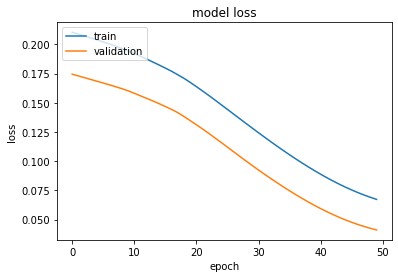

---------VALIDATION WITH ARPA---------
Values predicted:  [[18.072432]
 [18.809158]
 [18.563591]
 [18.674627]
 [18.901081]
 [18.55826 ]
 [18.504671]
 [18.27003 ]
 [18.522879]]
Values :  [[17.625     ]
 [24.625     ]
 [22.375     ]
 [22.625     ]
 [22.16666667]
 [19.        ]
 [19.75      ]
 [16.        ]
 [20.5       ]]
Mean Absolute Error:  2.580539985939309
Mean Squared Error:  9.51428452312142
Mean (Y-test): 20.51851851851852
Mean (Y-predicted):  18.541859
R2 score:  -0.44765862242281607
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  2.737424890686866
Mean Squared Error:  11.049324207015616
Mean (Y-test): 18.203066539115646
Mean (Y-predicted):  18.69973155430385
R2 score:  0.07836357795741977
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                110       
_____________________________________________________________

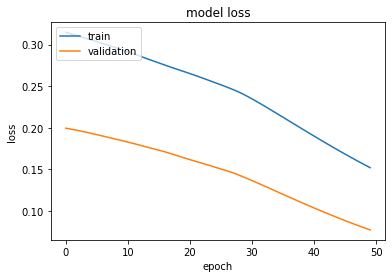

---------VALIDATION WITH ARPA---------
Values predicted:  [[14.675366]
 [14.76458 ]
 [15.556171]
 [15.442782]
 [15.900322]
 [13.668604]
 [13.511538]
 [15.191727]
 [13.469707]]
Values :  [[13.75      ]
 [18.875     ]
 [17.28571429]
 [12.125     ]
 [27.875     ]
 [18.        ]
 [11.6125    ]
 [18.        ]
 [11.875     ]]
Mean Absolute Error:  3.632355938260517
Mean Squared Error:  23.10451043823258
Mean (Y-test): 16.599801587301588
Mean (Y-predicted):  14.686756
R2 score:  0.019334838111336405
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  2.7530222165252627
Mean Squared Error:  14.23171170483754
Mean (Y-test): 15.44968665932991
Mean (Y-predicted):  14.96333197889657
R2 score:  0.11061578668089367
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                110       
____________________________________________________________

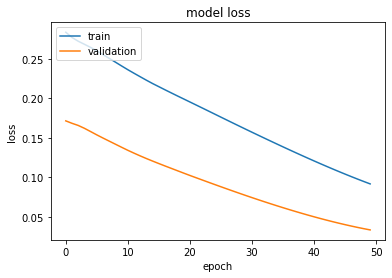

---------VALIDATION WITH ARPA---------
Values predicted:  [[14.588991]
 [14.707709]
 [13.880487]
 [14.727165]
 [14.412346]
 [14.115017]
 [14.455836]
 [13.385876]
 [14.998785]]
Values :  [[16.09090909]
 [16.27575758]
 [12.81818182]
 [14.90909091]
 [12.09090909]
 [20.        ]
 [16.        ]
 [15.66666667]
 [21.72727273]]
Mean Absolute Error:  2.563784414991385
Mean Squared Error:  10.97302369556809
Mean (Y-test): 16.175420875420873
Mean (Y-predicted):  14.363578
R2 score:  -0.3112527900476054
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  4.468938438828228
Mean Squared Error:  32.749063382863206
Mean (Y-test): 18.059387378192508
Mean (Y-predicted):  14.606457052559689
R2 score:  -0.3935482628319025
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                110       
___________________________________________________________

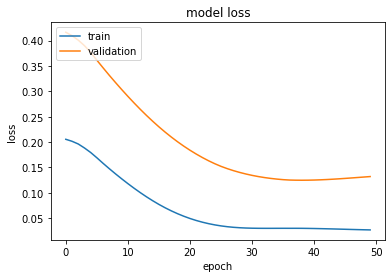

---------VALIDATION WITH ARPA---------
Values predicted:  [[12.62529  ]
 [12.355269 ]
 [12.4257145]
 [12.195043 ]
 [12.247565 ]
 [11.728045 ]
 [12.640264 ]
 [12.341096 ]
 [12.374327 ]]
Values :  [[13.875     ]
 [13.875     ]
 [12.675     ]
 [12.1875    ]
 [11.76071429]
 [12.14285714]
 [10.71428571]
 [12.375     ]
 [14.625     ]]
Mean Absolute Error:  0.9042762937999907
Mean Squared Error:  1.4576354967424487
Mean (Y-test): 12.692261904761905
Mean (Y-predicted):  12.325847
R2 score:  -0.09587778948803827
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  1.4064792117294
Mean Squared Error:  3.4744436359532753
Mean (Y-test): 12.973979591836734
Mean (Y-predicted):  12.337129626955305
R2 score:  -0.03614385675476428
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                110       
________________________________________________

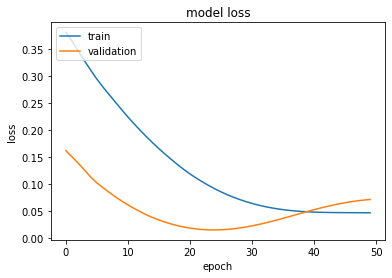

---------VALIDATION WITH ARPA---------
Values predicted:  [[33.950897]
 [34.284668]
 [29.530922]
 [27.801022]
 [36.87601 ]
 [29.910248]
 [34.489033]
 [33.996315]
 [25.612747]]
Values :  [[36.875     ]
 [35.61607143]
 [26.5       ]
 [31.25      ]
 [42.        ]
 [34.875     ]
 [27.25      ]
 [27.5       ]
 [20.875     ]]
Mean Absolute Error:  4.366360316200862
Mean Squared Error:  22.151214788957805
Mean (Y-test): 31.415674603174605
Mean (Y-predicted):  31.827982
R2 score:  0.41265086872440226
---------VALIDATION WITH CAMS---------
Mean Absolute Error:  4.507768236536558
Mean Squared Error:  27.340294661954093
Mean (Y-test): 30.217441273384356
Mean (Y-predicted):  32.65880407605852
R2 score:  0.3023357492342077


In [2]:
RESOLUTION = '0_1'
geopackages = os.listdir('grids_'+RESOLUTION)
#geopackages.remove('.DS_Store')

TARGET = 'pm25_st'
NUMBER_OF_PARAMS = 8
NUMBER_OF_COVARIATES = NUMBER_OF_PARAMS + 2




for grid in geopackages:
    data = gpd.read_file('grids_'+RESOLUTION+'/'+ grid)

    coll = pd.DataFrame()
    coll['pm25_st'] = data['pm25_st']
    coll['pm25_cams'] = data['pm25_cams']
    coll = coll.dropna(axis=0)

    #print('Mean Absolute Error: ',mean_absolute_error(coll['pm25_cams'], coll['pm25_st'], ))
    #print('Mean Squared Error: ',mean_squared_error(coll['pm25_cams'], coll['pm25_st']))
    #print('R2 score: ',r2_score(coll['pm25_cams'], coll['pm25_st']))


    data = data[~data[TARGET].isnull()]
    data = data.dropna(axis=1)


    data.pop('geometry')
    data.pop('bottom')
    data.pop('top')
    data.pop('left')
    data.pop('right')


    labels = pd.read_csv('features_' +RESOLUTION +'/'+grid[:-5]+'.csv')['Features']
    #labels = pd.read_csv('fs.csv')['Features']

    labels = ml.remove_int_values(labels.tolist())
    #data.pop('pm25_cams')
    #labels.remove('pm25_cams')


    #read variables which are not null
    score_results = pd.DataFrame()

    #Store dataset in x and y variables
    X = pd.DataFrame(data=data, columns=labels ).dropna(axis = 1)
    X = X.iloc[:, :NUMBER_OF_PARAMS]
    X['lat_cen'] = data['lat_cen']
    X['lng_cen'] = data['lng_cen']

    Y = pd.DataFrame(data=data, columns=[TARGET] )
    Y = Y.values.ravel()


    #NUMBER_OF_COVARIATES = X.shape[1]
    y1 = np.array(Y)

    X_train, X_val, y_train, y_val = train_test_split(X, y1, test_size=0.30)

    y_train=np.reshape(y_train, (-1,1))
    y_val=np.reshape(y_val, (-1,1))

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_x.fit(X_train)
    xtrain_scale=scaler_x.transform(X_train)
    scaler_x.fit(X_val)
    xval_scale=scaler_x.transform(X_val)

    scaler_y.fit(y_train)
    ytrain_scale=scaler_y.transform(y_train)
    scaler_y.fit(y_val)
    yval_scale=scaler_y.transform(y_val)

    model = Sequential()
    model.add(Dense(NUMBER_OF_COVARIATES, input_dim=NUMBER_OF_COVARIATES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(NUMBER_OF_COVARIATES/2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

    print('---------'+ grid +'---------')

    history=model.fit(xtrain_scale, ytrain_scale, epochs=50, batch_size=xtrain_scale.shape[0], verbose=1, validation_split=0.30)
    predictions = model.predict(xval_scale)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.plot(history.history['accuracy'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = scaler_y.inverse_transform(predictions)

    print('---------VALIDATION WITH ARPA---------')
    print('Values predicted: ', predictions)
    print('Values : ', scaler_y.inverse_transform(yval_scale))

    print('Mean Absolute Error: ',mean_absolute_error(y_val, predictions))
    print('Mean Squared Error: ',mean_squared_error(y_val, predictions))
    print('Mean (Y-test):',np.mean(y_val))
    print('Mean (Y-predicted): ',np.mean(predictions))
    print('R2 score: ',r2_score(y_val, predictions))

    #%%

    data_new = gpd.read_file('grids_'+RESOLUTION+'/'+ grid)
    data_new = data_new[~data_new[TARGET].isnull()]
    pm25_obs = data_new['pm25_st']
    X_new = pd.DataFrame(data=data_new, columns=labels).dropna(axis=1)
    X_new = X_new.iloc[:, :NUMBER_OF_PARAMS]

    X_new['lat_cen'] = data_new['lat_cen']
    X_new['lng_cen'] = data_new['lng_cen']
    scaler_x = MinMaxScaler()
    scaler_x.fit(X_new)
    X_new_scale=scaler_x.transform(X_new)




    predictions_pm25 = model.predict(X_new_scale,  batch_size=1)
    predictions_pm25 = pd.Series(np.array(scaler_y.inverse_transform(predictions_pm25)).reshape((-1,)))
    e = pd.DataFrame()

    e['predictions_pm25'] = list(predictions_pm25)
    e['pm25_obs'] = list(pm25_obs)
    e = e.dropna(axis=0)
    print('---------VALIDATION WITH CAMS---------')
    print('Mean Absolute Error: ',mean_absolute_error(e['pm25_obs'], e['predictions_pm25']))
    print('Mean Squared Error: ',mean_squared_error(e['pm25_obs'], e['predictions_pm25']))
    print('Mean (Y-test):',np.mean(e['pm25_obs']))
    print('Mean (Y-predicted): ',np.mean(e['predictions_pm25']))
    print('R2 score: ',r2_score(e['pm25_obs'], e['predictions_pm25']))